In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import  fisk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  r2_score

In [98]:
df_income_data = pd.read_csv('income.csv')
df_income_data.set_index('year', inplace=True)

df_gini_data = pd.read_csv('giniIndex.csv')
df_gini_data.set_index('year', inplace=True)

df_def_coef_data = pd.read_csv('DeflationCoefficient.csv')
df_def_coef_data.set_index('year', inplace=True)

In [99]:
df_modified_income = df_income_data.copy()
for year in df_modified_income.index:
    df_modified_income.loc[year] = df_modified_income.loc[year] * 1.49
    
df_log_income = df_modified_income.copy()
for year in df_log_income.index:
    df_log_income.loc[year] = np.log10(df_log_income.loc[year])

In [100]:
# Bootstrapping Function

def bootstrapping(X, y, size=1):
    regrList = []
    for n in range(size):
        inds = np.arange(int(len(X)/1))
        bs_inds = np.random.choice(inds, size=len(inds))

        Xcolumn = []
        Ycolumn = []

        for i in bs_inds:
            Xcolumn.append(X[i])
        for i in bs_inds:
            Ycolumn.append(y[i])

        Xcolumn = np.array(Xcolumn).reshape(len(inds), 1)
        Ycolumn = np.array(Ycolumn)

        regr = LinearRegression()
        regr.fit(Xcolumn, Ycolumn)
        regrList.append(regr)

    return regrList

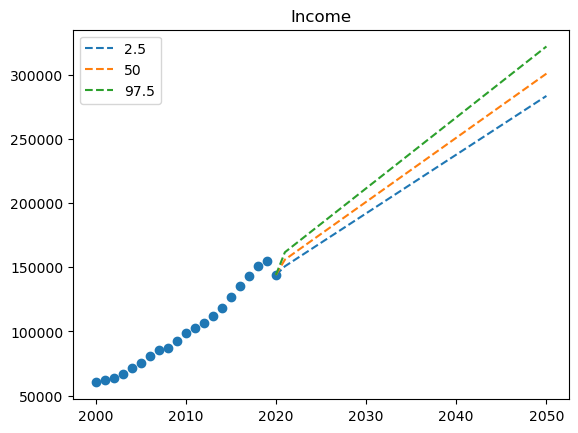

In [101]:
# Percentiles and Bootstrap

list_percentiles = [2.5, 50, 97.5]

X = np.array(df_modified_income.index)
y = np.array(df_modified_income['total'])

regrList = bootstrapping(X, y, 100)
yList = []

for regr in regrList:
    x = np.linspace(year_start + 1, year_end, year_end - year_start)
    x1 = x.reshape(len(x), 1)
    yfit = regr.predict(x1)
    yList.append(yfit[-1])

slope_ci = np.percentile(yList, list_percentiles)
regrRequire = {}

for i in list_percentiles:
    regr = regrList[closest(yList, slope_ci[list_percentiles.index(i)])]
    regrRequire[i] = regr

    x_plot = list(x)
    x_plot.insert(0, year_start)
    y_hat = list(regr.predict(x1))
    y_hat.insert(0, y[-1])
    plt.plot(x_plot, y_hat, linestyle="--", label=i)

plt.title('Income')
plt.scatter(X, y)
plt.legend()
plt.show()

2000  (alpha, beta): (0.04981188984619718, 2.994011976047904)
2010  (alpha, beta): (0.07941460433430325, 2.8169014084507045)
2020  (alpha, beta): (0.11681275373972819, 2.770083102493075)
2030  (alpha, beta): (0.15336774805401365, 2.770083102493075)
2040  (alpha, beta): (0.18992274236829917, 2.770083102493075)
2050  (alpha, beta): (0.22647773668258617, 2.770083102493075)


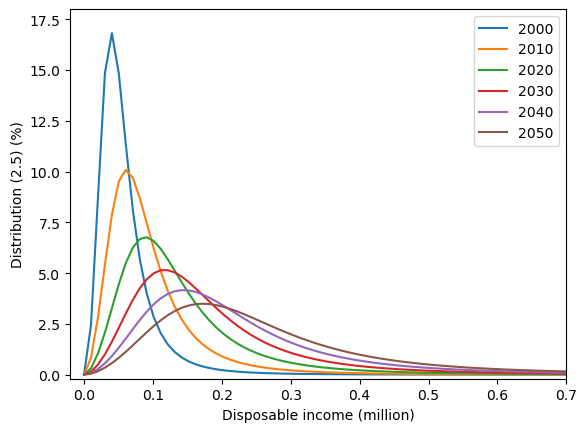

2000  (alpha, beta): (0.04981188984619718, 2.994011976047904)
2010  (alpha, beta): (0.07941460433430325, 2.8169014084507045)
2020  (alpha, beta): (0.12061923166691253, 2.770083102493075)
2030  (alpha, beta): (0.16053116346919016, 2.770083102493075)
2040  (alpha, beta): (0.20044309527146775, 2.770083102493075)
2050  (alpha, beta): (0.24035502707374534, 2.770083102493075)


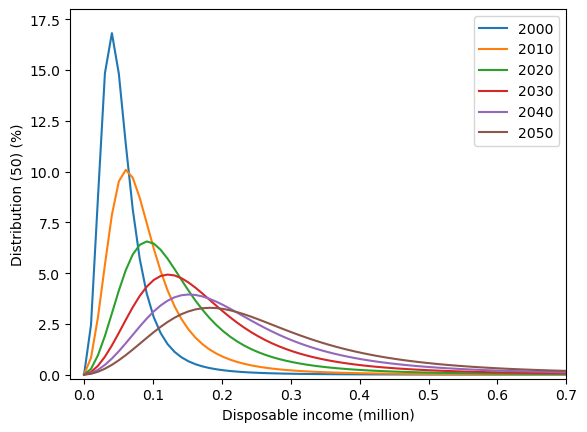

2000  (alpha, beta): (0.04981188984619718, 2.994011976047904)
2010  (alpha, beta): (0.07941460433430325, 2.8169014084507045)
2020  (alpha, beta): (0.12479405975161763, 2.770083102493075)
2030  (alpha, beta): (0.16894586610377738, 2.770083102493075)
2040  (alpha, beta): (0.2130976724559386, 2.770083102493075)
2050  (alpha, beta): (0.25724947880809834, 2.770083102493075)


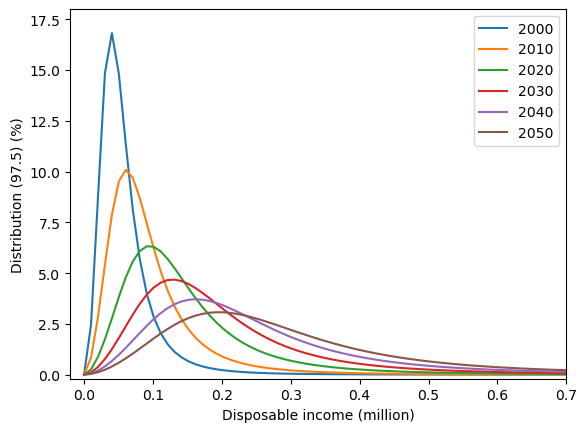

R-squared: 0.9607194796062121


In [116]:
# Log-Logistic Distribution

def LogLogisticDistribution(x, a, b):
    return fisk.pdf(x, b, 0, a)

def findBetaWithGini(year):
    year_gini_max = max(df_gini_data['gini'].index)
    if year <= max(df_gini_data['gini'].index):
        gini = df_gini_data['gini'][year]
    else:
        gini = df_gini_data['gini'][year_gini_max]
    return 1.0 / gini

incomePast = {}
incomeFuture = {}

for y in df_modified_income.index:
    incomeFuture[y] = df_modified_income['total'][y]

pars_log_future = {}

for m in list_percentiles:
    for y in range(df_modified_income.index[0], df_modified_income.index[-1] + 1):
        incomePast[y] = float(regrRequire[m].predict(np.array(y).reshape(1, 1)))

    for y in range(2020, 2051):
        incomeFuture[y] = float(regrRequire[m].predict(np.array(y).reshape(1, 1)))

    pars_log = {}

    for year in incomeFuture.keys():
        b = findBetaWithGini(year)
        a = findAlphaWithMean(b, incomeFuture[year] / 1000000)

        pars_log[year] = (a, b)

        pars = pars_log[year]
        if(year % 10 == 0):
            plt.plot(np.linspace(0, 1, 100), LogLogisticDistribution(np.linspace(0, 1, 100), *pars), '-', label=year)
            print(year, ' (alpha, beta):', pars)

    pars_log_future[m] = pars_log

    plt.xlabel('Disposable income (million)')
    plt.ylabel(f'Distribution ({m}) (%)')
    plt.xlim(-0.02, .7)
    plt.ylim(-0.2, 18)
    plt.legend()

    plt.savefig(f'income_distribution_{m}.png')
    plt.show()

r2 = r2_score(df_modified_income['total'], list(incomePast.values()))
print('R-squared:', r2)

# Saving Results

for m in list_percentiles:
    df_pars_log = pd.DataFrame.from_dict(pars_log_future[m], orient='index', columns=['alpha', 'beta'])
    df_pars_log.index.name = 'year'
    df_pars_log.to_csv(f'pars_incomeDistribution_{m}.csv')
